# Project #

Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them. Write python code which allows one to search through the images looking for the occurrences of keywords and faces.

Each page of the newspapers is saved as a single PNG image. These newspapers are in english, and contain a variety of stories, advertisements and images.

I could find many faces but I also got more false positives. I am planning to add image processing techniques that I have recently learnt to improve the results.

In [1]:
import zipfile

from PIL import Image, ImageFont, ImageDraw
import pytesseract
import cv2 as cv
import numpy as np
import math

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# 1. Dealing with Zip Files

In [2]:
def extract_zipfile(file):
    ''' reads a zip file and returns a list with the names inside the given zipfile.
    :param file: string with the direction of the zip file.
    '''
    read_zip = zipfile.ZipFile(file)
    read_zip_names = read_zip.namelist()
    images = []
    for i in range(len(read_zip_names)):
        images.append(Image.open(read_zip.extract(read_zip_names[i] )))
    
    return images, read_zip_names

# 2. Dealing with face recognition

In [3]:
# Draw rectangles on faces over our original image
def draw_rects(faces, image,width):
    from PIL import ImageDraw
    image_copy = image.copy()
    drawing=ImageDraw.Draw(image_copy)
    for x,y,w,h in image_faces:
            drawing.rectangle((x,y,x+w,y+h), outline="white",width = 6)
    #display(image_copy)

# creating crops
def crops(image_faces, faces_crops):
    for x,y,w,h in image_faces:
        faces_crops.append(image.crop((x, y, w+x,y+h)))    
    return faces_crops

In [4]:
def cv_greyscale(image, name_to_save):
    cv_conversion_image = image.convert("L")
    cv_conversion_image.save( name_to_save )
    return cv.imread( name_to_save )
    

# 3. Dealing with big letters in crops

In [5]:
# This function detecs if only few colors are used in an image, suggesting the content are letters and no images.
def crops_letters_check(image_crop, colors_threshold):
    rgb_colors = []
    
    for x in range(0, image_crop.width, 10):
        for y in range (0, image_crop.height, 10):
            rgb = image_crop.getpixel((x,y))
            if rgb not in rgb_colors:
                rgb_colors.append(rgb)
            if len(rgb_colors) > colors_threshold:
                return False
    return True


In [6]:
# use cropped images to check if they corresponds to letters

def lst_crops_letters_check(faces_crops, colors_threshold ):
    letters_check = []
    for img in faces_crops:
        letters_check.append(crops_letters_check(img, colors_threshold))
    true_counter = 0
    for i in range(len(letters_check)):
        if letters_check[i] :
            true_counter = true_counter + 1
    return letters_check, true_counter

# 4. Dealing with Contact sheets and crops

In [7]:
class crop_images_contactsheet:
    def __init__(self, img_dict):
        self.width_per_image = 150
        self.height_per_image = 150
        self.fontsize = 25
        self.text_space = 5

In [8]:
def height_contactsheet(img_dict):
    
    width_per_image = 150
    height_per_image = 150
    fontsize = 25
    text_space = 5
    
    # calculates the height of the contact sheet 
    height = 0
    for i in range(len(img_dict)):
        if img_dict[i][3]:
            if len(img_dict[i][0]) > 0:
                page_heigth = height_per_image * math.ceil(((len(img_dict[i][0]) - img_dict[i][2]) / 5))
                height = height + page_heigth
            # text height
            height = height + fontsize + text_space  
    
    # creation of the contact sheet
    return Image.new(img_dict[0][5], (width_per_image*5, height))
    
    

In [9]:
# img_dict[i] = {faces_crops, letters_check, true_counter, bool_word, read_zip_names, mode}
# creation of the contact sheet
def crop_images_contactsheet(img_dict, contact_sheet):
    width_per_image = 150
    height_per_image = 150
    fontsize = 25
    text_space = 5    
   
    # This is to draw letters in the contact sheet
    canvas = ImageDraw.Draw(contact_sheet)
    font = ImageFont.truetype("readonly/fanwood-webfont.ttf", fontsize)

    # pasting the content of the dictionary into de contact sheet

    y = 0
    for j in range(len( img_dict )):
        x = 0
        if img_dict[j][3]:
            if len(img_dict[j][0]) > 0:
                i = 0        
                while i < len( img_dict[j][0] ):
                    img = img_dict[j][0][i]
                    if not img_dict[j][1][i] :
                        # resizing the crops to fit the contact sheet
                        x_resize = width_per_image
                        y_resize = math.ceil((width_per_image / img.width ) * img.height)
                        img1 = img.resize( (x_resize,y_resize), Image.NEAREST)
                        contact_sheet.paste(img1, (x, y) )
                        if x + width_per_image == contact_sheet.width: # i == len( img_dict[j][0] )-1
                            x = 0
                            y=y + height_per_image
                        else:
                             x = x + width_per_image
                    i = i + 1
                if x != 0:                    
                    y = y + height_per_image
                    
                # We include the text after the image
                x = 0
                canvas.text((x,y + text_space ), "Results found in file: {}".format(img_dict[j][4][j]),
                            fill = "white", font=font)   
                y = y +  fontsize
            else:
                canvas.text((x,y + text_space ), "Word found but no faces in file: {}".format(img_dict[j][4][j]),
                            fill = "white", font=font)
                y = y +  fontsize
        #else:
         #   canvas.text((x,y + text_space ), "Word not found in file: {}".format(img_dict[j][4][j]),
          #                  fill = "white", font=font)

    display(contact_sheet)
    

# 5. Dealing with Characters Recognition

For this part I will use THRESH_BINARY, because if an image is detected as letters anyway it is difficult for an image to randomly generate a full word with meaning.

In [10]:
def letter_in_image(cv_image):
    cv_img_bin=cv.threshold(cv_image,178,255,cv.THRESH_BINARY)[1]
    # Get the text generated by pytesseract
    text = pytesseract.image_to_string(cv_img_bin)
    
    # We now get rid of non letters characters
    import string
    only_letters = ""
    for letter in text:
        if letter.lower() in string.ascii_lowercase:
            only_letters = only_letters + letter.lower()
    return only_letters

In [11]:
# This functions looks for the word in the only_letters list.
def checking_word(word, only_letters):
    word_lower = ""
    for i in range(len(word)):
        word_lower = word_lower + word[i].lower()

    if word_lower in only_letters:
        #print("The word appears in this page.")
        return True
    else: 
        #print("The word does not appear in this page.")
        return False
    

# Here Starts to run the Program

In [12]:

#file = "readonly/small_img.zip"
file = "readonly/small_img.zip"
images, read_zip_names = extract_zipfile(file)

if len(images) > 0:
    mode = images[0].mode
else: print("The archive is empty")
# This defines the width of the rectangles to draw in the images showing faces
width = 8

# In this dictionary we will collect the info for each page analyzed
img_dict = {}

### Give the number of image you want to analyze i, and the word you want to search for

for i in range(len(read_zip_names )):

    word = "Christopher"
    faces_crops = []
    letters_check = []
    true_counter = 0

    # First we make the transformation to be able to work with the image


    image = images[i]
    name_to_save = "image{}.png".format(i)
    cv_image = cv_greyscale(image, name_to_save ) # This is a numpy

    # We get the words in the image and check if the given word is in this list, if not we can skip to the next image

    only_letters = letter_in_image(cv_image)

    bool_word = checking_word(word, only_letters)

    # THRESH_TOZERO gave the best results. To try other methods see Appendix 1 at the end of the notebook

    ### Applying THRESH_TOZERO - This was the best algortihm

    if bool_word == True:
        # Get faces using threshold from cv
        cv_img_bin=cv.threshold(cv_image,182,255,cv.THRESH_TOZERO)[1] # 182 (ALMOST PERFECT),180 (VERY GOOD),178(WORSE),176(BETTER) ,170
        # Now do the actual face detection
        image_faces = face_cascade.detectMultiScale(cv_img_bin)
        # Now lets see the results
        draw_rects(image_faces,image,width)



    #We proceed to obtain the crops from THRESH_TOZERO since this algorithm gave the best results

    # obtaining the crops from the original if the given word is in this page
    if bool_word == True:
        faces_crops = crops(image_faces,faces_crops )

    if bool_word == True:
        # now we check if the crops are not big letters instead of faces
        colors_threshold = 10 # if less than "colors_threshold" are in the crop image, it is considered to contain a big letter
        letters_check, true_counter = lst_crops_letters_check(faces_crops, colors_threshold )

    ### Next we store the information with the results corresponding to the analyzis of this page

    img_dict[i] = [faces_crops, letters_check, true_counter, bool_word, read_zip_names, mode] 


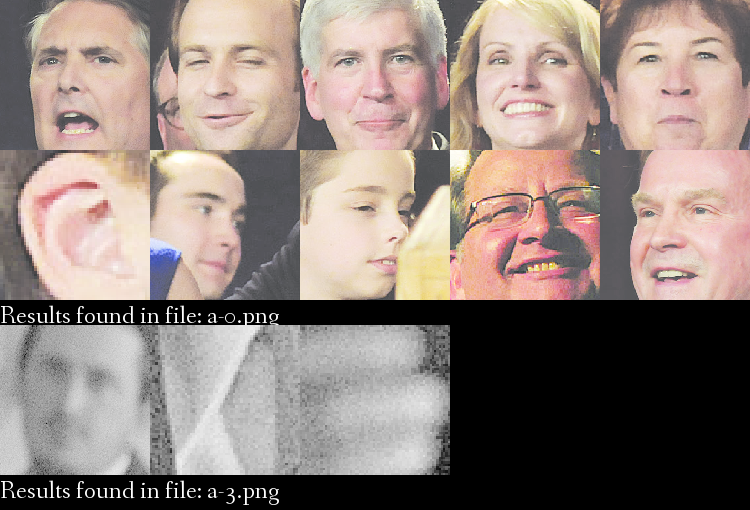

In [13]:
### Finally we show the full results in the contactsheet
# This creates the contactsheet
crop_images_contactsheet(img_dict, height_contactsheet(img_dict))

# Here ends my code

# Appendix 1

The following were attemtps made instead of using THRESH_TOZERO, which gave the best results, you can try any of 
the following methods if you wish to see other results.

### Applying detectMultiScale without factor

In [ ]:
# apply face_cascade without factor
image_faces = face_cascade.detectMultiScale(cv_image)
draw_rects(image_faces, image, width)

Without factor produces a lot of false negatives

### Applying detectMultiScale with factor > 1

In [ ]:
# Get the faces from face_cascade with given factor
def face_cascade_factor(cv_image,factor):
    width = 8
    image_faces = face_cascade.detectMultiScale(cv_image, factor)
    draw_rects(image_faces, image,width)

# try factor = 1.05, 1.15,1.25,1.5,
factor = 1.05
face_cascade_factor(cv_image,factor)


The scale factor does not apply significant change to the results without factor

### Applying THRESH_BINARY

In [ ]:
# Get faces using threshold from cv
cv_img_bin=cv.threshold(cv_image,178,255,cv.THRESH_BINARY)[1] # 190, 180 (best),178(THE BEST),176 (best),170, (good), 160,
# Now do the actual face detection
image_faces = face_cascade.detectMultiScale(cv_img_bin)
# Now lets see the results
draw_rects(image_faces,image,width)

# Appendix 2

The following was an attempt with kraken but it is too slow and sadly kraken does not run on windows right now

In [ ]:
#def show_boxes(image):
#    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
#    :param img: A PIL.Image object
#    :return img: The modified PIL.Image object
#    '''
#   from PIL import ImageDraw
#    from kraken import pageseg
    
#    drawing_object=ImageDraw.Draw(image)
#    bounding_boxes=pageseg.segment(image.convert("1"))['boxes']
#    for box in bounding_boxes:
#        drawing_object.rectangle(box, fill = None, outline ='red',width = 6 )
#    return img

In [ ]:
#display(cv_conversion_image)

In [ ]:
#cv_image_kraken = cv_conversion_image.copy()

In [ ]:
#display(show_boxes(cv_image_kraken))